# Apply Gaussian Mixture Modeling (GMM) to UKESM1 ozone dataset

This example notebook contains code used to apply GMM to the UKESM1 ozone dataset.

## Initial setup

#### Import modules

We used scikit-learn (sklearn), matplotlib, pandas cartopy, and numpy

In [1]:
!pip install texttable latextable

In [2]:
#import scikit-learn
from sklearn import mixture
from sklearn import preprocessing
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

# import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib as mpl

# import pandas, numpy, etc.
import pandas as pd
import numpy as np
import os.path
import random
import pickle
import xarray as xr
import json

# for label map
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import mpl_toolkits

# for automatic table formatting
from texttable import Texttable
import latextable



#### Set parameters

Here we select number of classes based on BIC score and manually. There are many other ways than BIC to justify choices when it comes to the number of classes.

In [3]:
# number of components (before manual grouping)
n_components_selected = 10

#saving figures
save_figs = False

# manual grouping
manual_grouping = False

# manual grouping vector
manual_classes = [0, 0, 1, 2, 3, 4, 5, 5]

# check to make sure that n_comp is as expected (uncomment this to check n_comp)
#n_comp = best_gmm.n_components

# set n_comp to manually selected value based on our further grouping
if manual_grouping==True:
    n_comp_manual = 6
    n_comp = n_comp_manual
else:
    n_comp = n_components_selected

#### Import data

Here we combine ozone profiles experiments into a single training dataset from:

     1) Historical: Annual means covering the years 2004-2014
     2) SSP1-2.6: Annual means covering the years 2090-2100 (strong emission reductions)
     3) SSP5-8.5: Annual means covering the years 2090-2100 (no emission reductions)
     
GMM will be trained on this combined dataset, such that it is exposed to the full variety of ozone states in the dataset. This will make the model more general than if it had only been trained on a single scenario. 

In [4]:
#import data
data1 = pd.read_csv('data_in/historical_seasonal.csv')
data2 = pd.read_csv('data_in/ssp126_seasonal.csv')
data3 = pd.read_csv('data_in/ssp585_seasonal.csv')
data = data1.append([data1,data2,data3], ignore_index=True) #append data
data #data load

/tmp/ipykernel_3703/358274946.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data1.append([data1,data2,data3], ignore_index=True) #append data


,x,y,season,1000,925,850,700,600,500,400,...,200,150,100,70,50,30,20,10,5,1
0,0.9375,-89.375,DJF,NaN,NaN,0.000000,0.099991,1.317870,1.275637,1.339549,...,4.697723,4.587994,5.397292,8.749182,12.559555,12.841137,9.390033,4.856805,2.673725,0.204272
1,0.9375,-89.375,JJA,NaN,NaN,0.000000,0.039306,1.683980,1.477666,1.281533,...,2.541174,5.368797,10.433466,16.512575,15.625815,9.196220,6.558020,2.781719,1.010234,0.169674
2,0.9375,-89.375,MAM,NaN,NaN,0.000000,0.038577,1.336666,1.227627,1.182483,...,4.361568,5.909919,9.756591,14.610302,15.168732,10.096333,6.584430,3.567123,1.779331,0.232079
3,0.9375,-89.375,SON,NaN,NaN,0.000000,0.074782,1.541470,1.391227,1.271945,...,2.324337,4.662927,4.703378,4.604415,5.159846,6.753445,6.899643,4.422953,2.297504,0.221742
4,2.8125,-89.375,DJF,NaN,NaN,0.000000,0.098728,1.317713,1.275441,1.339394,...,4.697357,4.587856,5.396471,8.748376,12.558534,12.841625,9.391102,4.857012,2.673738,0.204271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442359,357.1875,89.375,MAM,3.197045,3.143483,3.110951,3.141170,3.029033,2.807894,2.675290,...,12.147468,21.561138,26.759465,26.567406,22.772397,16.389281,12.865323,7.441234,3.977507,0.346113
442360,357.1875,89.375,SON,3.264681,3.206568,3.168741,3.109062,2.952354,2.708826,2.418583,...,6.246322,10.505812,13.739154,16.610936,16.521086,12.498409,8.821268,5.321466,3.065838,0.351077
442361,359.0625,89.375,DJF,3.053687,2.911132,2.790603,2.611595,2.489740,2.283158,2.044946,...,5.133944,10.372397,17.838699,21.718482,20.744612,15.345332,11.425738,6.518369,3.296892,0.278449
442362,359.0625,89.375,JJA,3.004739,3.343178,3.626347,3.869779,3.826420,3.700889,3.470816,...,11.679680,17.567568,16.079520,16.266056,16.099107,12.749317,9.638267,5.780284,3.564140,0.263063


#### Set aside unmodified original dataset, extract ozone values, longitudes, latitudes, and years 

Pressures are in hPa (vertical coordinate), latitudes and longitudes are in degrees, and ozone concentrations are in mPa.

In [48]:
# highest pressure index
col_of_highest_pressure = 5

# keep 'data' as the unmodified original
data_cleaned = data

# drop rows (profiles) with NaNs
data_cleaned = data_cleaned.dropna()
data_cleaned = data_cleaned.reset_index(drop=True)

# extract pressure values from the column headers
p = data_cleaned.columns[col_of_highest_pressure:].values

# let's work with the cleaned up dataset
df = data_cleaned

# get the latitudes, and longitudes for each profile
lon = df.iloc[:,0].values
lat = df.iloc[:,1].values
season = df.iloc[:,2].values

# get the array that will be used to fit the GMM object
X = df.iloc[:,col_of_highest_pressure:].values

# count the number of profiles in the full, combined dataset
nProfiles = X[:,1].size

# examine df (dataframe) 
df

,x,y,season,1000,925,850,700,600,500,400,...,200,150,100,70,50,30,20,10,5,1
0,177.1875,-83.125,MAM,1.383903,1.678320,1.657465,1.446490,1.337898,1.247056,1.238386,...,4.681407,6.238642,10.321542,15.071902,15.400838,10.348359,6.909717,3.868468,2.000040,0.261746
1,179.0625,-83.125,DJF,1.604381,1.461070,1.431194,1.295044,1.272436,1.289241,1.369077,...,4.920904,4.621442,5.851460,9.695220,13.675340,13.202995,9.527873,4.978482,2.722723,0.207378
2,179.0625,-83.125,JJA,1.817576,2.163283,2.140656,1.872173,1.697532,1.501339,1.323276,...,3.129133,6.073562,11.681914,17.247997,15.646292,9.318910,6.655041,2.985649,1.189483,0.190634
3,179.0625,-83.125,MAM,1.333090,1.679371,1.648923,1.447523,1.339414,1.248646,1.237913,...,4.676286,6.240200,10.323661,15.069964,15.400617,10.356893,6.919504,3.872515,2.001274,0.261737
4,179.0625,-83.125,SON,1.937284,1.946686,1.900258,1.669138,1.553489,1.428723,1.330284,...,2.912946,5.071537,4.757649,5.161971,6.067680,8.122412,8.024857,5.190364,2.704918,0.233543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327191,357.1875,89.375,MAM,3.197045,3.143483,3.110951,3.141170,3.029033,2.807894,2.675290,...,12.147468,21.561138,26.759465,26.567406,22.772397,16.389281,12.865323,7.441234,3.977507,0.346113
327192,357.1875,89.375,SON,3.264681,3.206568,3.168741,3.109062,2.952354,2.708826,2.418583,...,6.246322,10.505812,13.739154,16.610936,16.521086,12.498409,8.821268,5.321466,3.065838,0.351077
327193,359.0625,89.375,DJF,3.053687,2.911132,2.790603,2.611595,2.489740,2.283158,2.044946,...,5.133944,10.372397,17.838699,21.718482,20.744612,15.345332,11.425738,6.518369,3.296892,0.278449
327194,359.0625,89.375,JJA,3.004739,3.343178,3.626347,3.869779,3.826420,3.700889,3.470816,...,11.679680,17.567568,16.079520,16.266056,16.099107,12.749317,9.638267,5.780284,3.564140,0.263063


## Preprocessing: principal component analysis 

Here we carry out PCA for dimensionality reduction

#### Standardise the data

In [49]:
Xscaled = preprocessing.scale(X) #scaling

#### Use PCA for dimensionality reduction

In [60]:
# create PCA object
pca = PCA(n_components=8)

# fit PCA model
pca.fit(Xscaled)

# transform input data into PCA representation
Xpca = pca.transform(Xscaled)

# calculated total variance explained
total_variance_explained_ = np.sum(pca.explained_variance_ratio_) 
total_variance_explained_

0.9921269034816853

Visualizing the eigenfunctions

In [53]:
#ploting the eigenfunctions
y = pca.components_
y1 = y[:,:]

#orginal pressure levels
z = data_cleaned.columns[col_of_highest_pressure:].values

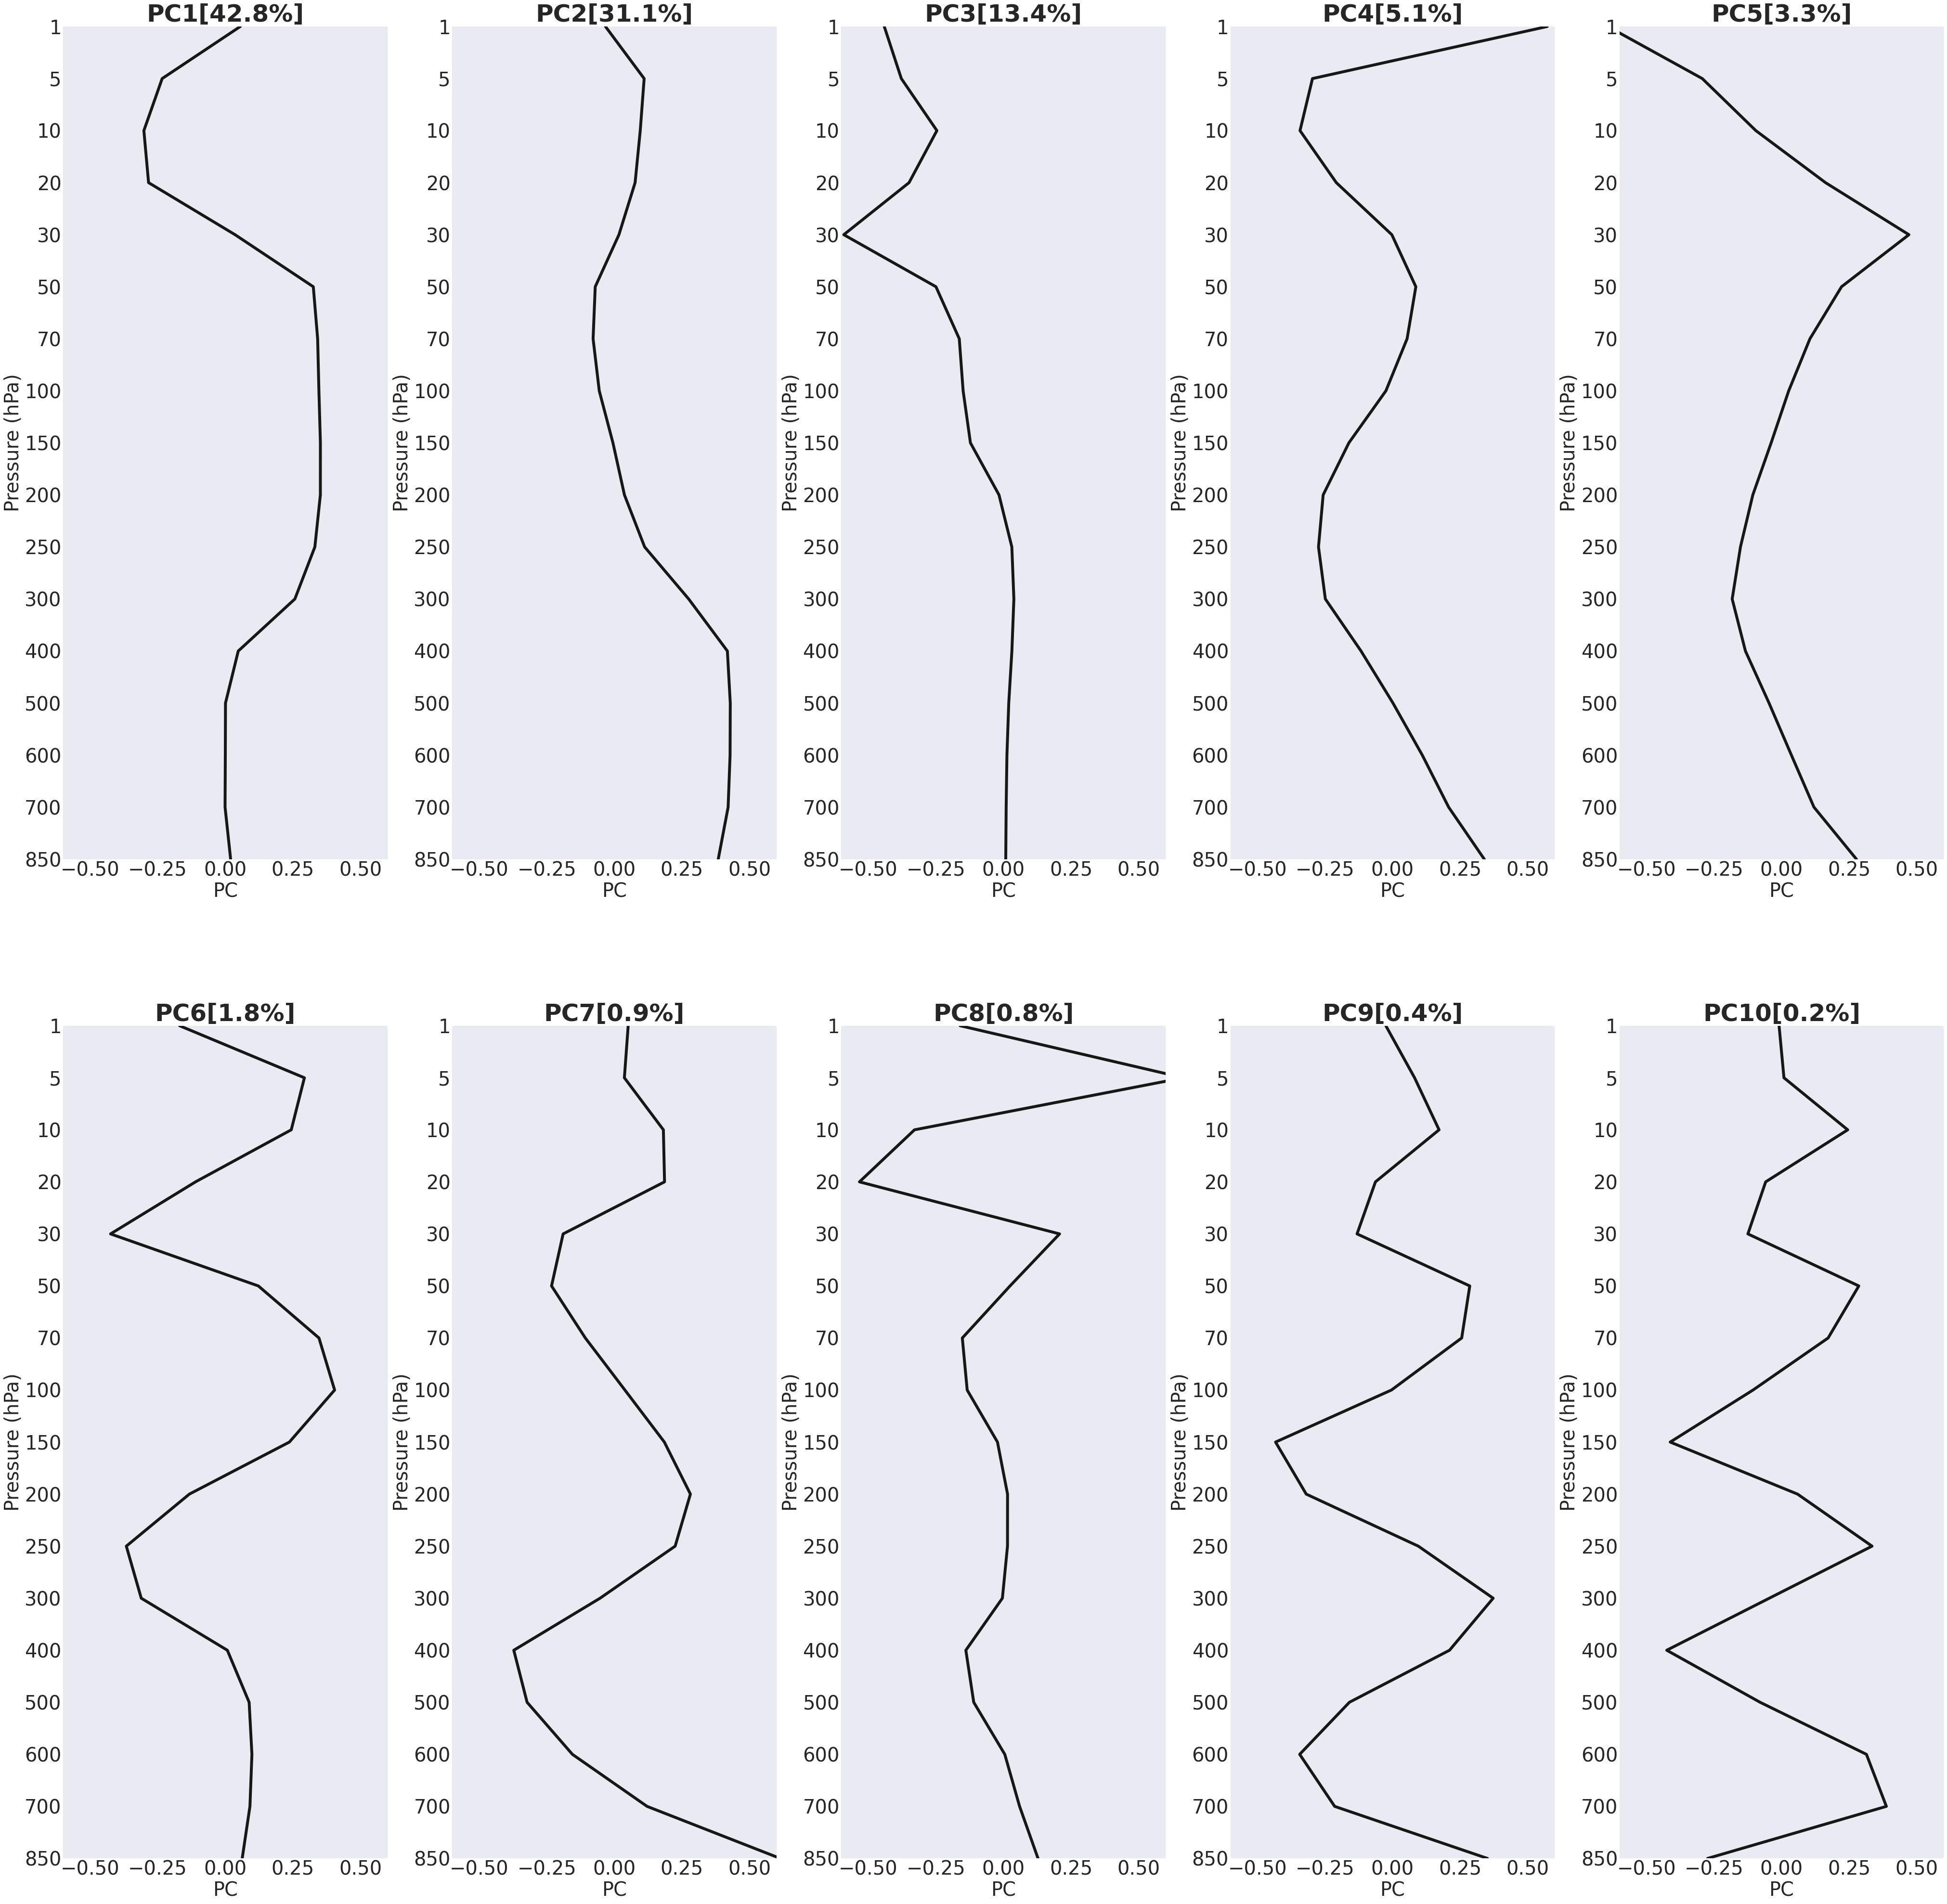

In [54]:
plt.figure(figsize = (70,70))
plt.style.use('seaborn-darkgrid')

num = 0

# iterate over groups
for npca in range(pca.n_components):
    num = num + 1
    
    # select subplot
    ax = plt.subplot(2,5,num)
    plt.plot(y1[npca,:], z, marker='', linestyle='solid',
                 color='black', linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    plt.grid()
    plt.ylim([min(z), z[0]])
    plt.xlim([-.6, .6])
    #text box
    fs = 24 # font size

    plt.xlabel('PC', fontsize=40)
    plt.ylabel('Pressure (hPa)', fontsize=40)
    plt.title('PC' + str(npca+1) + \
              '[' + str(round(pca.explained_variance_ratio_[npca]*100,1)) + '%]', fontsize=50, fontweight="bold")
              
                  
    # font and axis stuff
    plt.gca().invert_yaxis()
    ax.tick_params(axis='x', labelsize=40)
    ax.tick_params(axis='y', labelsize=40)
    # save figure and close
    #plt.savefig("figures/pca.pdf", bbox_inches='tight',dpi=300)

## Finding minimum BIC score for best Gaussian mixture model

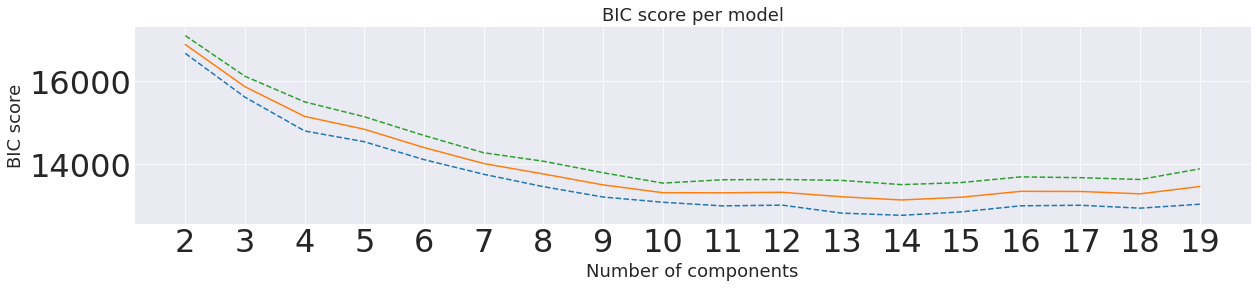

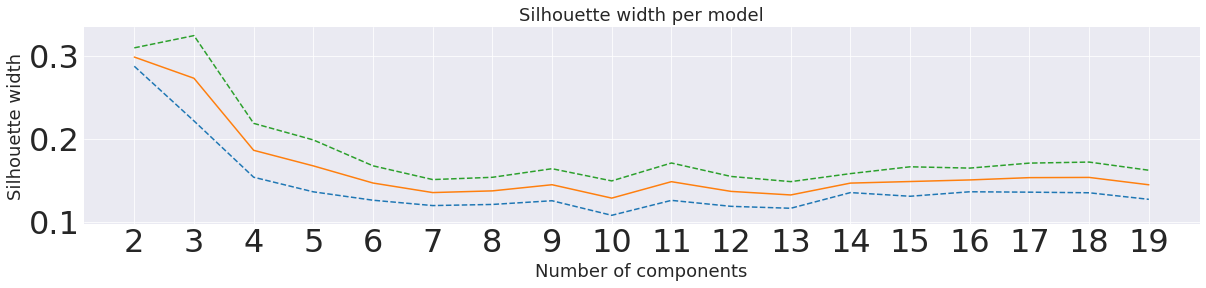

In [55]:
# if file exists, then load it. Otherwise, calculate best GMM model
#mloc = '../../src/models/'
if os.path.isfile( 'models/n' + str(n_components_selected) + 'best_gmm_means.npy'):

    # set gmm_loaded flag to true
    gmm_loaded = True
    print('Found a GMM file, loading pre-fit GMM')
    
    # reload
    gmm_name = 'models/n' + str(n_components_selected) + 'best_gmm'
    means = np.load(gmm_name + '_means.npy')
    covar = np.load(gmm_name + '_covariances.npy')
    loaded_gmm = mixture.GaussianMixture(n_components = len(means), covariance_type='full')
    loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
    loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
    loaded_gmm.means_ = means
    loaded_gmm.covariances_ = covar
    best_gmm = loaded_gmm

else:
    
    # set gmm_loaded flag to true
    gmm_loaded = False
    
    # select parameters
    max_N = 20     # the maximum number of classes to try 
    max_bic_iter = 20  # the maximum number of iterations for BIC

    # initialise, declare variables
    lowest_bic = np.infty
    bic_scores = np.zeros((2,max_bic_iter))
    silhouette_scores = np.zeros((2,max_bic_iter))

    # loop through the maximum number of classes, estimate BIC
    n_components_range = range(2, max_N)
    bic_iter_range = range(0,max_bic_iter)
    
    # iterate through all the covariance types (just 'full' for now)
    cv_types = ['full']
    
    for cv_type in cv_types:
        # iterate over all the possible numbers of components
        for n_components in n_components_range:
            
            # empty BIC and silhouette arrays
            bic_one = []
            sil_one = []
            
            # repeat the BIC step for better statistics
            for bic_iter in bic_iter_range:
                
                # select a new random subset
                rows_id = random.sample(range(0,Xpca.shape[0]-1), 1000)
                Xpca_for_BIC = Xpca[rows_id,:]
                
                # fit a Gaussian mixture model
                gmm = mixture.GaussianMixture(n_components=n_components,
                                              covariance_type=cv_type,
                                              random_state=42)

                # uncomment for 'rapid' BIC fitting
                gmm.fit(Xpca_for_BIC)
                # uncomment for 'full' BIC fitting
                #gmm.fit(Xpca)
                # append this BIC score to the list
                bic_one.append(gmm.bic(Xpca_for_BIC))
                
                # get labels and silhouette score
                # The silhouette_score gives the average value for all the samples.
                # This gives a perspective into the density and separation of the formed
                # clusters
                cluster_labels_tmp = gmm.predict(Xpca_for_BIC)
                sil_tmp = silhouette_score(Xpca_for_BIC, cluster_labels_tmp)
                sil_one.append(sil_tmp)
                
                # clear this for the next BIC iteration
                Xpca_for_BIC = []
                
            # stack the bic and silhouette scores into a single 2D structure
            bic_scores = np.vstack((bic_scores, np.asarray(bic_one)))
            silhouette_scores = np.vstack((silhouette_scores, np.asarray(sil_one)))

    # BIC plot ----------------
            
    # the first two rows are not needed; they were only placeholders
    bic_scores = bic_scores[2:,:]

    # mean values for BIC
    bic_mean = np.mean(bic_scores, axis=1)

    # standard deviation for BIC
    bic_std = np.std(bic_scores, axis=1)

    # examine the mean bic values
    #bic_mean

    # plot the BIC scores
    plt.figure(figsize=(20, 8))
    plt.style.use('seaborn-darkgrid')
    spl = plt.subplot(2, 1, 1)
    plt.plot(n_components_range, bic_mean-bic_std, '--')  
    plt.plot(n_components_range, bic_mean, '-')  
    plt.plot(n_components_range, bic_mean+bic_std, '--')  
    plt.xticks(n_components_range)
    #plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('BIC score per model', fontsize=18)
    spl.set_xlabel('Number of components',fontsize=18)
    spl.set_ylabel('BIC score',fontsize=18)
    #plt.show()

    # save figure
    #plt.savefig(ploc+"BIC score per model (UKESM)",
    #           bbox_inches="tight",transparent=False)
    
    # Silhouette score plot ----------------
            
    # the first two rows are not needed; they were only placeholders
    silhouette_scores = silhouette_scores[2:,:]

    # mean values for silhouette
    silhouette_mean = np.mean(silhouette_scores, axis=1)

    # standard deviation for BIC
    silhouette_std = np.std(silhouette_scores, axis=1)

    # examine the mean bic values
    #bic_mean

    # plot the BIC scores
    plt.figure(figsize=(20, 8))
    plt.style.use('seaborn-darkgrid')
    spl = plt.subplot(2, 1, 1)
    plt.plot(n_components_range, silhouette_mean-silhouette_std, '--')  
    plt.plot(n_components_range, silhouette_mean, '-')  
    plt.plot(n_components_range, silhouette_mean+silhouette_std, '--')  
    plt.xticks(n_components_range)
    plt.title('Silhouette width per model', fontsize=18)
    spl.set_xlabel('Number of components',fontsize=18)
    spl.set_ylabel('Silhouette width',fontsize=18)

In [11]:
# if the file exists, it should already be loaded. Print it out. 
if gmm_loaded==True:
    
    # print out best_gmm
    print('GMM has been pre-fit and it already loaded')
    best_gmm
    
else:
    
    # fit the "best" GMM model using the full Xpca dataset
    best_gmm = mixture.GaussianMixture(n_components=n_components_selected, 
                                       covariance_type='full', 
                                       random_state=42)
    best_gmm.fit(Xpca)
    # save to file
    gmm_name = 'models/n' + str(n_components_selected) + 'best_gmm' 
    np.save(gmm_name + '_weights', best_gmm.weights_, allow_pickle=False)
    np.save(gmm_name + '_means', best_gmm.means_, allow_pickle=False)
    np.save(gmm_name + '_covariances', best_gmm.covariances_, allow_pickle=False)

    
best_gmm

GaussianMixture(n_components=5, random_state=42)

In [12]:
# assign class labels ("predict" the class using the selected GMM)
labels = best_gmm.predict(Xpca)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs = best_gmm.predict_proba(Xpca)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs = np.max(posterior_probs,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
df.insert(3,'label',labels,True)
df.insert(4,'max posterior prob',max_posterior_probs,True) 

# print out best_gmm parameters
df

,x,y,season,label,max posterior prob,1000,925,850,700,600,...,200,150,100,70,50,30,20,10,5,1
0,177.1875,-83.125,MAM,3,0.999998,1.383903,1.678320,1.657465,1.446490,1.337898,...,4.681407,6.238642,10.321542,15.071902,15.400838,10.348359,6.909717,3.868468,2.000040,0.261746
1,179.0625,-83.125,DJF,4,1.000000,1.604381,1.461070,1.431194,1.295044,1.272436,...,4.920904,4.621442,5.851460,9.695220,13.675340,13.202995,9.527873,4.978482,2.722723,0.207378
2,179.0625,-83.125,JJA,3,1.000000,1.817576,2.163283,2.140656,1.872173,1.697532,...,3.129133,6.073562,11.681914,17.247997,15.646292,9.318910,6.655041,2.985649,1.189483,0.190634
3,179.0625,-83.125,MAM,3,1.000000,1.333090,1.679371,1.648923,1.447523,1.339414,...,4.676286,6.240200,10.323661,15.069964,15.400617,10.356893,6.919504,3.872515,2.001274,0.261737
4,179.0625,-83.125,SON,4,1.000000,1.937284,1.946686,1.900258,1.669138,1.553489,...,2.912946,5.071537,4.757649,5.161971,6.067680,8.122412,8.024857,5.190364,2.704918,0.233543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327191,357.1875,89.375,MAM,3,1.000000,3.197045,3.143483,3.110951,3.141170,3.029033,...,12.147468,21.561138,26.759465,26.567406,22.772397,16.389281,12.865323,7.441234,3.977507,0.346113
327192,357.1875,89.375,SON,1,1.000000,3.264681,3.206568,3.168741,3.109062,2.952354,...,6.246322,10.505812,13.739154,16.610936,16.521086,12.498409,8.821268,5.321466,3.065838,0.351077
327193,359.0625,89.375,DJF,3,1.000000,3.053687,2.911132,2.790603,2.611595,2.489740,...,5.133944,10.372397,17.838699,21.718482,20.744612,15.345332,11.425738,6.518369,3.296892,0.278449
327194,359.0625,89.375,JJA,1,1.000000,3.004739,3.343178,3.626347,3.869779,3.826420,...,11.679680,17.567568,16.079520,16.266056,16.099107,12.749317,9.638267,5.780284,3.564140,0.263063


In [13]:
# group by label
grouped_unsorted = df.groupby('label')

# calculate mean of all profiles in each class
df_means = grouped_unsorted.mean()
oz_means = df_means['y'].values
old2new = np.argsort(oz_means)

# create dictionary object for sorting
di = dict(zip(old2new,range(0,n_components_selected)))

# add new column to dataframe - sorted label
df.insert(4,'label_sorted',df['label'].map(di))

# examine dataframe
df

,x,y,season,label,label_sorted,max posterior prob,1000,925,850,700,...,200,150,100,70,50,30,20,10,5,1
0,177.1875,-83.125,MAM,3,3,0.999998,1.383903,1.678320,1.657465,1.446490,...,4.681407,6.238642,10.321542,15.071902,15.400838,10.348359,6.909717,3.868468,2.000040,0.261746
1,179.0625,-83.125,DJF,4,0,1.000000,1.604381,1.461070,1.431194,1.295044,...,4.920904,4.621442,5.851460,9.695220,13.675340,13.202995,9.527873,4.978482,2.722723,0.207378
2,179.0625,-83.125,JJA,3,3,1.000000,1.817576,2.163283,2.140656,1.872173,...,3.129133,6.073562,11.681914,17.247997,15.646292,9.318910,6.655041,2.985649,1.189483,0.190634
3,179.0625,-83.125,MAM,3,3,1.000000,1.333090,1.679371,1.648923,1.447523,...,4.676286,6.240200,10.323661,15.069964,15.400617,10.356893,6.919504,3.872515,2.001274,0.261737
4,179.0625,-83.125,SON,4,0,1.000000,1.937284,1.946686,1.900258,1.669138,...,2.912946,5.071537,4.757649,5.161971,6.067680,8.122412,8.024857,5.190364,2.704918,0.233543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327191,357.1875,89.375,MAM,3,3,1.000000,3.197045,3.143483,3.110951,3.141170,...,12.147468,21.561138,26.759465,26.567406,22.772397,16.389281,12.865323,7.441234,3.977507,0.346113
327192,357.1875,89.375,SON,1,4,1.000000,3.264681,3.206568,3.168741,3.109062,...,6.246322,10.505812,13.739154,16.610936,16.521086,12.498409,8.821268,5.321466,3.065838,0.351077
327193,359.0625,89.375,DJF,3,3,1.000000,3.053687,2.911132,2.790603,2.611595,...,5.133944,10.372397,17.838699,21.718482,20.744612,15.345332,11.425738,6.518369,3.296892,0.278449
327194,359.0625,89.375,JJA,1,4,1.000000,3.004739,3.343178,3.626347,3.869779,...,11.679680,17.567568,16.079520,16.266056,16.099107,12.749317,9.638267,5.780284,3.564140,0.263063


In [14]:
# max label
print("Number of clusters (prior to manual grouping)")
df.label_sorted.max()+1

Number of clusters (prior to manual grouping)


5

In [15]:
# classes 4 and 5 (python 3 and 4) are so similar that they swap easily
# classes 7 and 8 (python 6 and 7) are very similar

if manual_grouping==True:
    df0 = df
    for i in range(0,n_components_selected):
        df.loc[df0.label_sorted==i, "label_sorted"] = manual_classes[i]

# check to see the highest-valued label
print("Number of clusters (after manual grouping)")
df.label_sorted.max()+1

Number of clusters (after manual grouping)


5

In [16]:
# group profiles according to label
grouped = df.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means = grouped.mean()

# calculate stdevs of all profiles in each class
dfg_stds = grouped.std()

# number or profiles in each class
nprofs = grouped['x'].count().values

# count number of profiles at each location
gbl = df.groupby('x')
Al1=gbl.count()['label_sorted']
nprofs_ = Al1[df['x'].values].values

dfg_means

,x,y,label,max posterior prob,1000,925,850,700,600,500,...,200,150,100,70,50,30,20,10,5,1
label_sorted,,,,,,,,,,,,,,,,,,,,,
0,187.282261,-52.419358,4.0,0.970052,2.088435,2.021899,1.988182,1.935019,1.840259,1.706393,...,4.671422,7.745608,11.118942,13.924359,15.387671,14.442489,11.858634,7.276186,3.992468,0.301296
1,193.848312,-0.713501,2.0,0.971006,2.497818,2.389829,2.507839,2.624763,2.511692,2.358558,...,1.086768,1.061552,1.977332,5.060830,9.080633,13.509230,14.995178,10.271664,4.579989,0.293611
2,191.622777,1.535852,0.0,0.951514,3.020380,3.032722,3.129240,3.170728,2.981010,2.722432,...,2.554569,3.464523,4.852015,7.722728,11.449058,14.317971,13.641726,9.014157,4.599473,0.291422
3,181.413036,47.175845,3.0,0.983164,2.400715,2.699569,2.800931,2.748128,2.583465,2.367352,...,7.598620,12.078644,16.576097,19.000675,18.546347,14.656776,11.114394,6.441658,3.443856,0.313800
4,176.157717,70.947586,1.0,0.985965,2.626378,2.818923,3.000030,3.121062,3.010217,2.813700,...,7.452899,10.085744,12.604957,14.771435,14.863970,12.064881,9.393245,5.816275,3.328753,0.295956


#### Check that the sorting worked correctly, examine means and stdevs

In [17]:
dfg_means['1000'] #at sfc

label_sorted
0    2.088435
1    2.497818
2    3.020380
3    2.400715
4    2.626378
Name: 1000, dtype: float64

#### Colormap selection

In [18]:
colormap = plt.get_cmap('tab10', n_comp)

## We will start working with each data set with the same PCA calculated earlier

#### Historical data (2004-2014)

In [19]:
# keep 'data' as the unmodified historical original dataset
data_cleaned1 = data1 #historical data

# drop rows with NaNs
data_cleaned1 = data_cleaned1.dropna()
data_cleaned1 = data_cleaned1.reset_index(drop=True)

#pressure values from the column headers
p1 = data_cleaned1.columns[3:].values

In [20]:
# let's work with the cleaned up historical datset dataset
df1 = data_cleaned1

# get the latitudes, and longitudes for each profile
lon = df1.iloc[:,0].values
lat = df1.iloc[:,1].values
year = df1.iloc[:,2].values

# get the array that will be used to fit the GMM object
X1 = df1.iloc[:,3:].values

# number of profiles for historical dataset
nProfiles1 = X1[:,1].size

# scale by variable 
Xscaled1 = preprocessing.scale(X1)

# check data frame
df1

,x,y,season,1000,925,850,700,600,500,400,...,200,150,100,70,50,30,20,10,5,1
0,177.1875,-83.125,MAM,1.383903,1.678320,1.657465,1.446490,1.337898,1.247056,1.238386,...,4.681407,6.238642,10.321542,15.071902,15.400838,10.348359,6.909717,3.868468,2.000040,0.261746
1,179.0625,-83.125,DJF,1.604381,1.461070,1.431194,1.295044,1.272436,1.289241,1.369077,...,4.920904,4.621442,5.851460,9.695220,13.675340,13.202995,9.527873,4.978482,2.722723,0.207378
2,179.0625,-83.125,JJA,1.817576,2.163283,2.140656,1.872173,1.697532,1.501339,1.323276,...,3.129133,6.073562,11.681914,17.247997,15.646292,9.318910,6.655041,2.985649,1.189483,0.190634
3,179.0625,-83.125,MAM,1.333090,1.679371,1.648923,1.447523,1.339414,1.248646,1.237913,...,4.676286,6.240200,10.323661,15.069964,15.400617,10.356893,6.919504,3.872515,2.001274,0.261737
4,179.0625,-83.125,SON,1.937284,1.946686,1.900258,1.669138,1.553489,1.428723,1.330284,...,2.912946,5.071537,4.757649,5.161971,6.067680,8.122412,8.024857,5.190364,2.704918,0.233543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81956,357.1875,89.375,MAM,2.500313,3.067424,3.230198,3.135224,2.983059,2.779645,2.648739,...,10.281789,13.435838,15.727700,16.843928,16.516593,13.484845,10.392876,5.967129,3.104414,0.275747
81957,357.1875,89.375,SON,2.298378,2.786175,2.896052,2.879639,2.707690,2.485387,2.330671,...,6.844200,8.949165,12.810509,15.039960,14.384839,10.861462,7.990345,4.569005,2.545042,0.284012
81958,359.0625,89.375,DJF,1.799965,2.446331,2.664229,2.573197,2.385582,2.171925,2.033299,...,6.613581,10.557016,15.837325,18.236601,16.799602,12.196462,9.018058,5.059220,2.522020,0.272950
81959,359.0625,89.375,JJA,3.024904,3.057908,3.362948,3.493059,3.362510,3.148649,3.020113,...,9.595268,10.131558,12.424713,14.435482,14.213897,10.573501,7.569845,4.970922,2.994963,0.225944


In [21]:
# transform input data into PCA representation
Xpca1 = pca.transform(Xscaled1)

# calculated total variance explained
total_variance_explained_ = np.sum(pca.explained_variance_ratio_) 
print("Total variance explained by principal component representation of dataset")
total_variance_explained_

Total variance explained by principal component representation of dataset


0.9952186057387792

In [22]:
# assign class labels ("predict" the class using the selected GMM)
labels1 = best_gmm.predict(Xpca1)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs1 = best_gmm.predict_proba(Xpca1)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs1 = np.max(posterior_probs1,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
df1.insert(3,'label',labels1,True)
df1.insert(4,'max posterior prob',max_posterior_probs1,True) 

# check data frame
print("Number of classes (before manual grouping)")
df1.label.max()+1

Number of classes (before manual grouping)


5

In [23]:
# group by label
grouped_unsorted1 = df1.groupby('label')

# calculate mean of all profiles in each class
df_means1 = grouped_unsorted1.mean()

oz_means1 = df_means1['y'].values

old2new1 = np.argsort(oz_means1)

# create dictionary object for sorting
di1 = dict(zip(old2new1,range(0,n_components_selected)))

# add new column to dataframe - sorted label
df1.insert(4,'label_sorted',df1['label'].map(di1))

In [24]:
grouped_unsorted1

In [25]:
# classes 4 and 5 (python 3 and 4) are so similar that they swap easily
# classes 7 and 8 (python 6 and 7) are very similar

if manual_grouping==True:
    df0 = df1
    for i in range(0,n_components_selected):
        df1.loc[df0.label_sorted==i, "label_sorted"] = manual_classes[i]

# check to see the highest-valued label
print("Number of classes (after manual grouping)")
df1.label_sorted.max()+1

Number of classes (after manual grouping)


5

In [26]:
# group profiles according to label
grouped1 = df1.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means1 = grouped1.mean()

# calculate stdevs of all profiles in each class
dfg_stds1 = grouped1.std()

# number or profiles in each class
nprofs1 = grouped1['x'].count().values

# count number of profiles at each location
gbl1 = df1.groupby('x')
Al1=gbl1.count()['label_sorted']
nprofs1_ = Al1[df1['x'].values].values
dfg_means1

,x,y,label,max posterior prob,1000,925,850,700,600,500,...,200,150,100,70,50,30,20,10,5,1
label_sorted,,,,,,,,,,,,,,,,,,,,,
0,185.085387,-53.922984,4.0,0.968677,2.149119,2.082761,2.040044,1.974386,1.873767,1.733026,...,4.222070,6.006863,8.344602,11.458627,13.860581,13.804678,11.397142,6.842208,3.609505,0.279017
1,197.553879,-0.616643,2.0,0.947179,2.759695,2.626777,2.707086,2.727929,2.582202,2.408566,...,1.123641,1.146236,2.179045,5.371762,9.235331,13.592437,15.099468,10.075474,4.278526,0.279140
2,190.904310,2.231915,0.0,0.940683,3.324103,3.307369,3.366738,3.334651,3.095890,2.794378,...,2.419950,3.053351,4.313345,7.211189,11.042011,14.090891,13.648898,8.860140,4.259266,0.276935
3,184.303967,47.749896,3.0,0.969351,2.424080,2.830775,2.957995,2.880714,2.689577,2.450705,...,7.128006,10.328070,14.000183,16.562499,16.584329,13.419144,10.219141,5.891847,3.111522,0.292170
4,169.230918,70.992566,1.0,0.968490,2.775870,2.962031,3.185824,3.298839,3.156495,2.928757,...,7.125695,8.555205,11.276182,13.646715,14.034187,11.765840,9.239791,5.674515,3.171135,0.271235


#### Plot the means and standard deviations of the classes by profile

In [27]:
dfg_means1

,x,y,label,max posterior prob,1000,925,850,700,600,500,...,200,150,100,70,50,30,20,10,5,1
label_sorted,,,,,,,,,,,,,,,,,,,,,
0,185.085387,-53.922984,4.0,0.968677,2.149119,2.082761,2.040044,1.974386,1.873767,1.733026,...,4.222070,6.006863,8.344602,11.458627,13.860581,13.804678,11.397142,6.842208,3.609505,0.279017
1,197.553879,-0.616643,2.0,0.947179,2.759695,2.626777,2.707086,2.727929,2.582202,2.408566,...,1.123641,1.146236,2.179045,5.371762,9.235331,13.592437,15.099468,10.075474,4.278526,0.279140
2,190.904310,2.231915,0.0,0.940683,3.324103,3.307369,3.366738,3.334651,3.095890,2.794378,...,2.419950,3.053351,4.313345,7.211189,11.042011,14.090891,13.648898,8.860140,4.259266,0.276935
3,184.303967,47.749896,3.0,0.969351,2.424080,2.830775,2.957995,2.880714,2.689577,2.450705,...,7.128006,10.328070,14.000183,16.562499,16.584329,13.419144,10.219141,5.891847,3.111522,0.292170
4,169.230918,70.992566,1.0,0.968490,2.775870,2.962031,3.185824,3.298839,3.156495,2.928757,...,7.125695,8.555205,11.276182,13.646715,14.034187,11.765840,9.239791,5.674515,3.171135,0.271235


Class1
Maximum at 50.0 hPa
Maximum ozone value of mean profile = 13.860581351972991
Standard deviation at level = 2.930549373585293
Class2
Maximum at 20.0 hPa
Maximum ozone value of mean profile = 15.099467643115728
Standard deviation at level = 0.7804270365751572
Class3
Maximum at 30.0 hPa
Maximum ozone value of mean profile = 14.090891218301692
Standard deviation at level = 2.128347488932834
Class4
Maximum at 50.0 hPa
Maximum ozone value of mean profile = 16.58432863072455
Standard deviation at level = 2.5789400085940617
Class5
Maximum at 50.0 hPa
Maximum ozone value of mean profile = 14.034187269003636
Standard deviation at level = 1.823934527027328


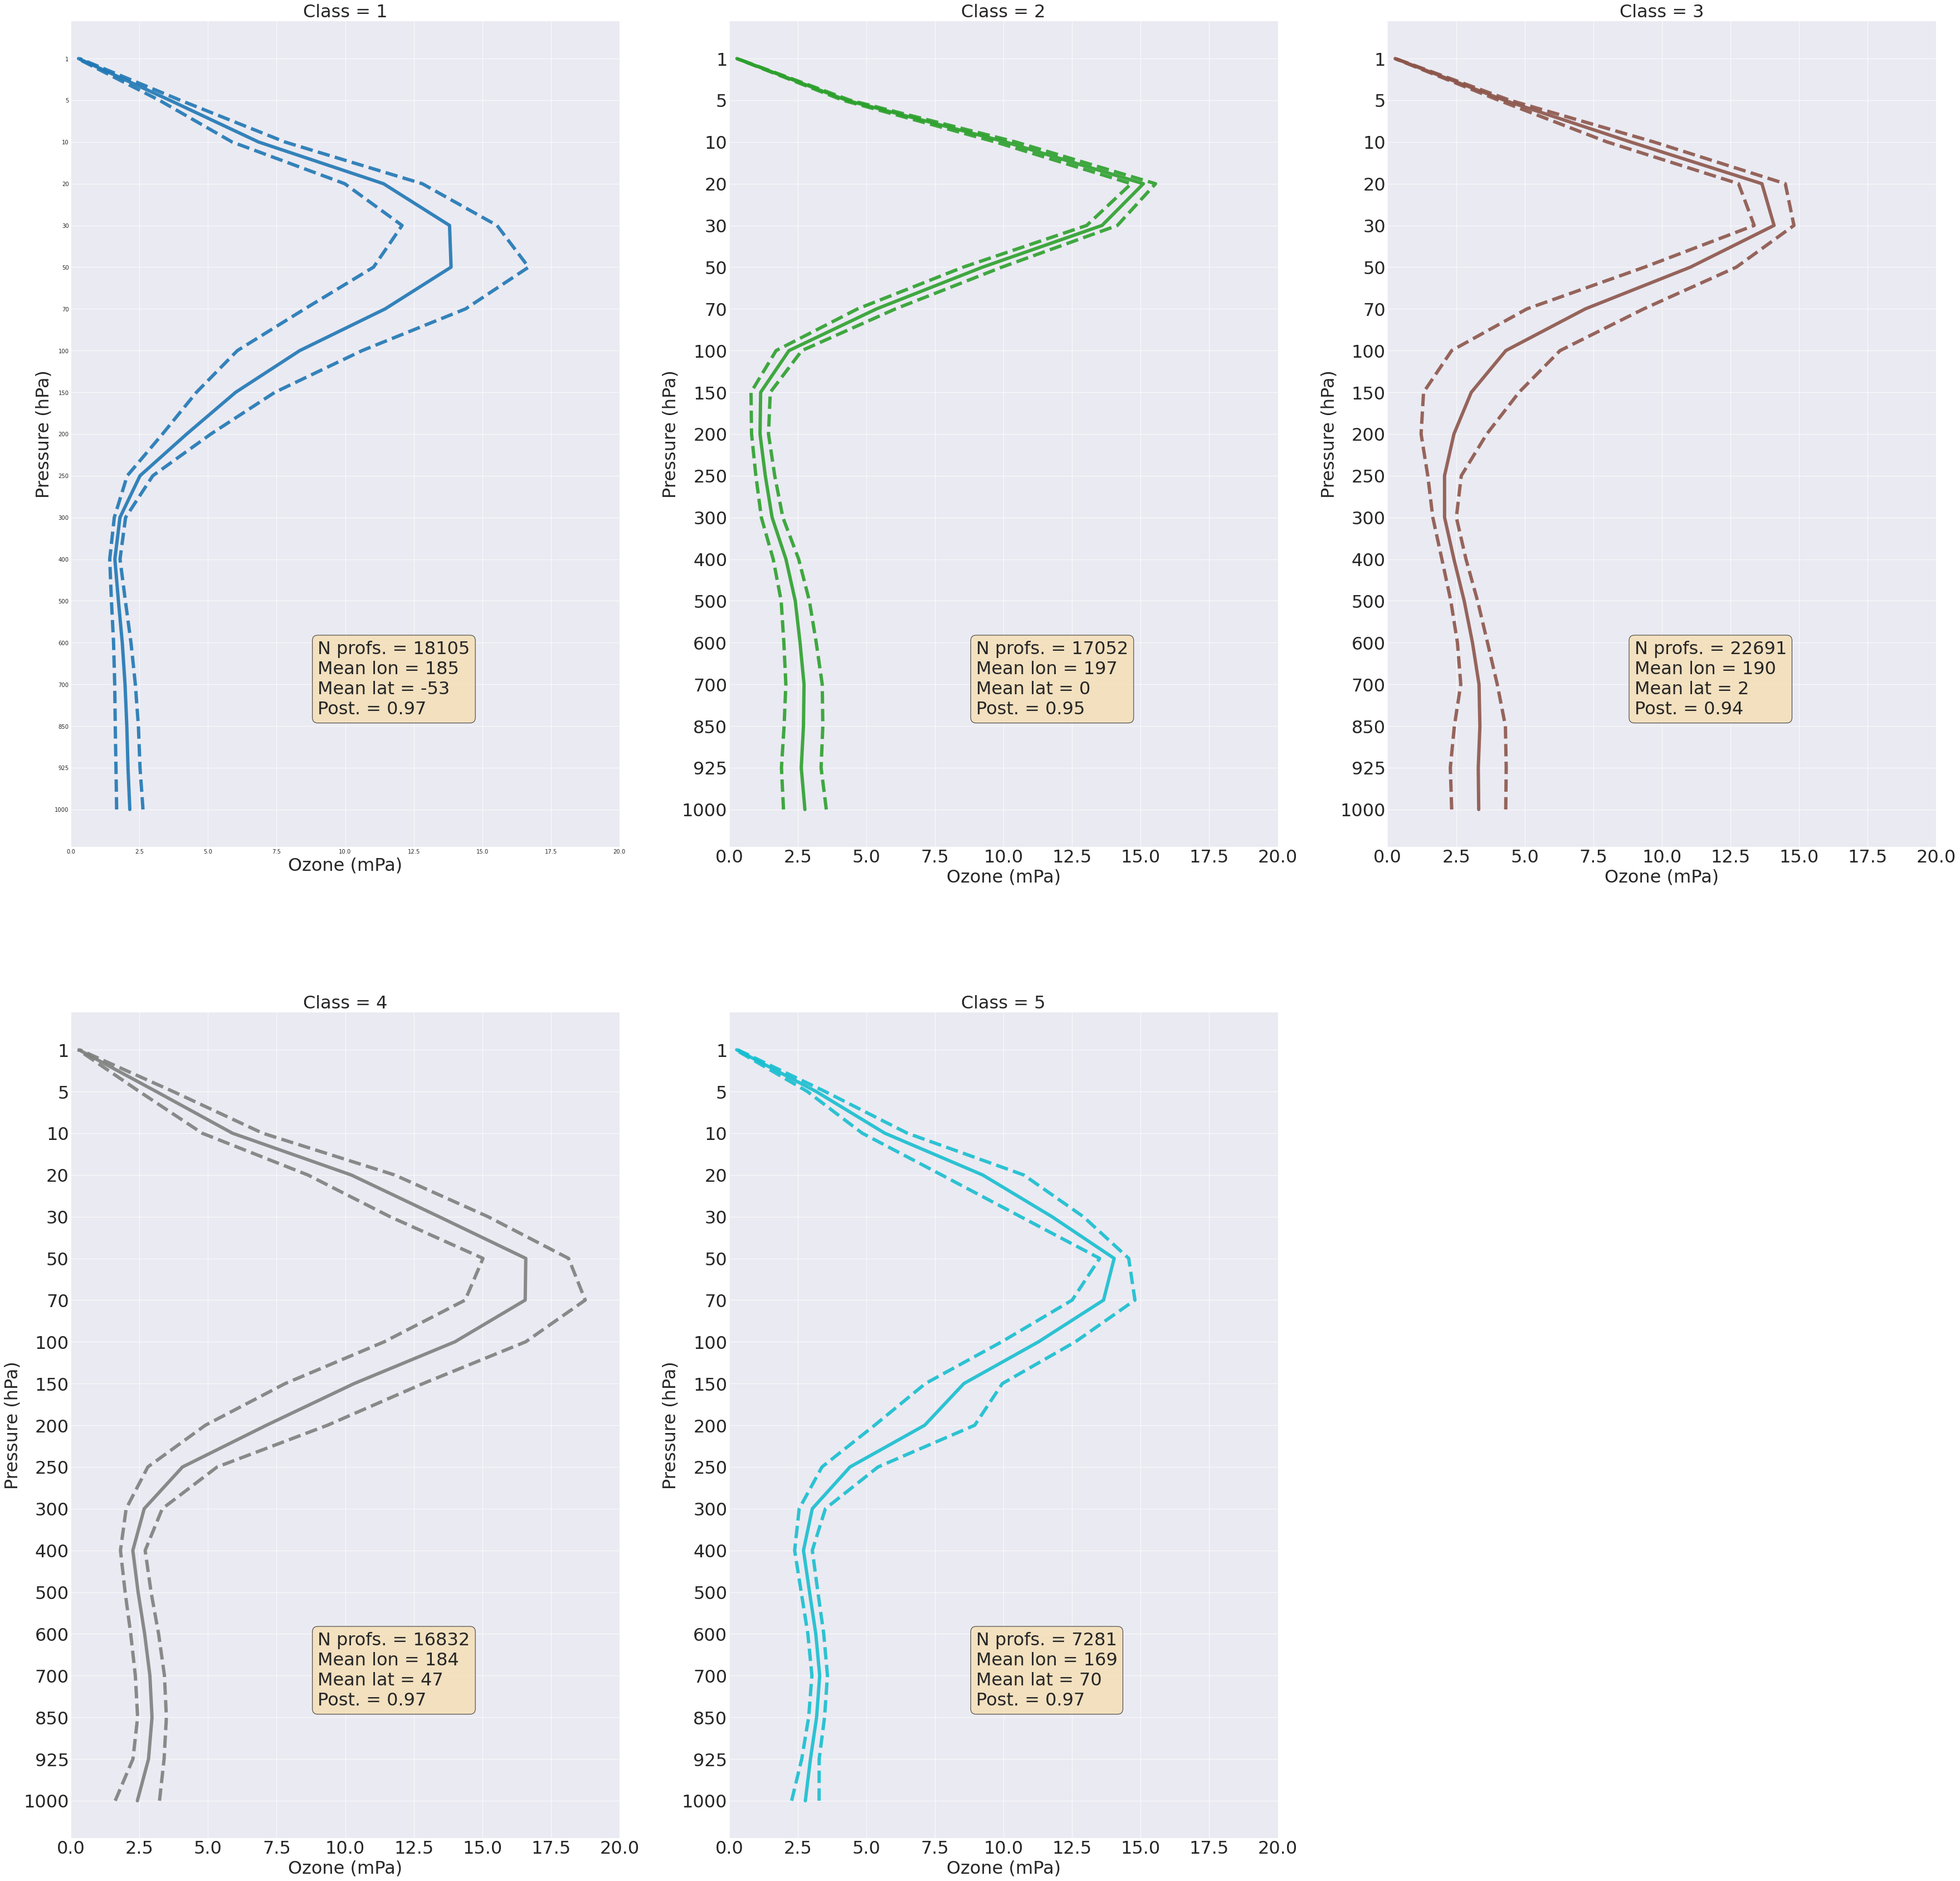

In [28]:
#classes for historical data set
cNorm = colors.Normalize(vmin=0, vmax=n_comp)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

max_ozone_pressure_hist = np.zeros(n_comp)
max_ozone_value_hist = np.zeros(n_comp)
std_ozone_value_hist = np.zeros(n_comp)

# initialize the figure
plt.figure(figsize=(60, 60))
plt.style.use('seaborn-darkgrid')
#palette = cmx.Paired(np.linspace(0,1,n_comp))
 
# iterate over groups
num = 0
for nrow in range(0,n_comp):
    num += 1
    colorVal = scalarMap.to_rgba(nrow)
     # extract means
    mean_lon1 = dfg_means1.iloc[nrow,0]
    mean_lat1 = dfg_means1.iloc[nrow,1]
    mean_maxpp1 = dfg_means1.iloc[nrow,3]
    mean_T1 = dfg_means1.iloc[nrow,4:].values
    
    # extract stdevs
    std_lon1 = dfg_stds1.iloc[nrow,0]
    std_lat1 = dfg_stds1.iloc[nrow,1]
    std_maxpp1 = dfg_stds1.iloc[nrow,3]
    std_T1 = dfg_stds1.iloc[nrow,4:].values
    
    # calculate it
    max_ozone_pressure_hist[nrow] = p[np.argmax(mean_T1)]
    max_ozone_value_hist[nrow] = np.max(mean_T1)
    std_ozone_value_hist[nrow] = np.max(std_T1)
    
    print('Class'+str(num))
    print('Maximum at ' + str(max_ozone_pressure_hist[nrow]) + ' hPa')
    print('Maximum ozone value of mean profile = ' + str(max_ozone_value_hist[nrow]))
    print('Standard deviation at level = ' + str(std_ozone_value_hist[nrow]))
    
    # select subplot
    #plt.subplot(np.ceil(n_comp/5),5,num)
    plt.subplot(int(np.ceil(n_comp/3)),3,num)
    plt.plot(mean_T1, p1, marker='', linestyle='solid', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T1+std_T1, p1, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T1-std_T1, p1, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    #plt.ylim([0,950])
    ax = plt.gca()
    #ax.invert_yaxis() 
    plt.xlim([0, 20])
    #ax.grid(True)
    
   #text box
    fs = 32 # font size
    plt.xlabel('Ozone (mPa)', fontsize=fs)
    plt.ylabel('Pressure (hPa)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    mpl.rc('xtick', labelsize=fs)     
    mpl.rc('ytick', labelsize=fs)
    
    # this creates the test boxes that display the class statistics
    textstr = '\n'.join((
        r'N profs. = %i' % (nprofs1[nrow], ),
        r'Mean lon = %i' % (mean_lon1, ),
        r'Mean lat = %i' % (mean_lat1, ),
        r'Post. = %.2f' % (mean_maxpp1, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    # place a text box in upper left in axes coords
    ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs,
            verticalalignment='top', bbox=props)   
   
   #plt.show()

# later, uncomment these to save the figures
plt.savefig("figures/historicalprofiles.pdf",
            bbox_inches="tight",transparent=False)

 

In the inset text boxes above, "N profs." is the number of profiles in each class. Also shown are class mean values for longitude, latitude, and maximum posterior probability.

In [29]:
df1

,x,y,season,label,label_sorted,max posterior prob,1000,925,850,700,...,200,150,100,70,50,30,20,10,5,1
0,177.1875,-83.125,MAM,3,3,0.999999,1.383903,1.678320,1.657465,1.446490,...,4.681407,6.238642,10.321542,15.071902,15.400838,10.348359,6.909717,3.868468,2.000040,0.261746
1,179.0625,-83.125,DJF,4,0,1.000000,1.604381,1.461070,1.431194,1.295044,...,4.920904,4.621442,5.851460,9.695220,13.675340,13.202995,9.527873,4.978482,2.722723,0.207378
2,179.0625,-83.125,JJA,3,3,1.000000,1.817576,2.163283,2.140656,1.872173,...,3.129133,6.073562,11.681914,17.247997,15.646292,9.318910,6.655041,2.985649,1.189483,0.190634
3,179.0625,-83.125,MAM,3,3,1.000000,1.333090,1.679371,1.648923,1.447523,...,4.676286,6.240200,10.323661,15.069964,15.400617,10.356893,6.919504,3.872515,2.001274,0.261737
4,179.0625,-83.125,SON,4,0,1.000000,1.937284,1.946686,1.900258,1.669138,...,2.912946,5.071537,4.757649,5.161971,6.067680,8.122412,8.024857,5.190364,2.704918,0.233543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81956,357.1875,89.375,MAM,3,3,1.000000,2.500313,3.067424,3.230198,3.135224,...,10.281789,13.435838,15.727700,16.843928,16.516593,13.484845,10.392876,5.967129,3.104414,0.275747
81957,357.1875,89.375,SON,3,3,0.893425,2.298378,2.786175,2.896052,2.879639,...,6.844200,8.949165,12.810509,15.039960,14.384839,10.861462,7.990345,4.569005,2.545042,0.284012
81958,359.0625,89.375,DJF,3,3,1.000000,1.799965,2.446331,2.664229,2.573197,...,6.613581,10.557016,15.837325,18.236601,16.799602,12.196462,9.018058,5.059220,2.522020,0.272950
81959,359.0625,89.375,JJA,1,4,1.000000,3.024904,3.057908,3.362948,3.493059,...,9.595268,10.131558,12.424713,14.435482,14.213897,10.573501,7.569845,4.970922,2.994963,0.225944


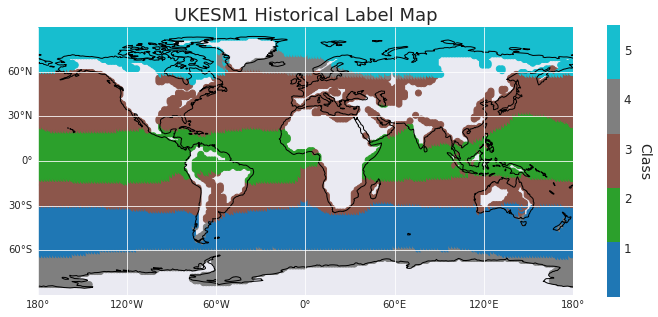

In [30]:
df1_djf = df1[df1.season=="JJA"]
#df1plot = df1.groupby(['x','y']).median().reset_index().drop(columns=['year'])
df1plot = df1_djf.groupby(['x','y']).median().reset_index()
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

cplot = df1plot['label_sorted'].values + 1

CS1 = plt.scatter(df1plot['x'].values, df1plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 

colorbar = plt.colorbar(CS1, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.ax.tick_params(labelsize='large')
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)

plt.title('UKESM1 Historical Label Map', fontsize=18) 
#plt.show()

# eventually, uncomment this in order to save the images
#if save_figs==True:
plt.savefig("figures/historical_labels",bbox_inches="tight",transparent=False)
#figfolder = './'
#plt.savefig(figfolder + "1.labels_historical",bbox_inches="tight",transparent=False)

#### PLot the label map for historical data

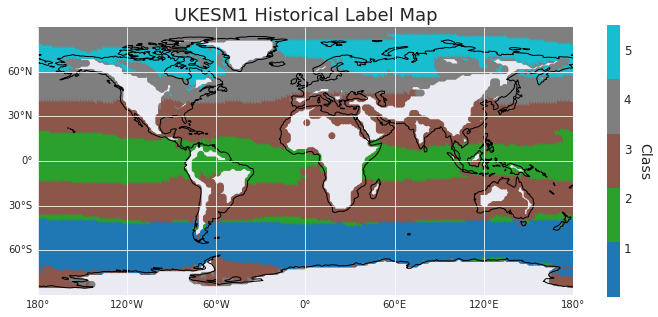

In [31]:
#df1plot = df1.groupby(['x','y']).median().reset_index().drop(columns=['year'])
df1plot = df1.groupby(['x','y']).median().reset_index()
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

cplot = df1plot['label_sorted'].values + 1

CS1 = plt.scatter(df1plot['x'].values, df1plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 

colorbar = plt.colorbar(CS1, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.ax.tick_params(labelsize='large')
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)

plt.title('UKESM1 Historical Label Map', fontsize=18) 
#plt.show()

# eventually, uncomment this in order to save the images
#if save_figs==True:
plt.savefig("figures/historical_labels",bbox_inches="tight",transparent=False)
#figfolder = './'
#plt.savefig(figfolder + "1.labels_historical",bbox_inches="tight",transparent=False)



## Calculation of the area occupied by each class

In [32]:
x = df1['x'].values
y = df1['y'].values

In [33]:
df1['cos_lat'] = np.cos(np.radians(df1['y']))
A1 = df1.groupby('label_sorted').sum()['cos_lat']

In [34]:
#area calculation
area_hist = 100*A1/np.sum(A1)
area_hist

label_sorted
0    19.067636
1    30.281542
2    35.224791
3    11.201464
4     4.224567
Name: cos_lat, dtype: float64

## We will repeat the process for future projection dataset

#### SSP1-2.6 (Annual mean from 2090-2100 with strong greenhouse emission reduction)

In [35]:
# keep 'data' as the unmodified original dataset
data_cleaned2 = data2 #ssp126

# drop rows with NaNs
data_cleaned2 = data_cleaned2.dropna()
data_cleaned2 = data_cleaned2.reset_index(drop=True)

# for simple plotting, extract an array of values 
A2 = data_cleaned2.drop(columns=['x','y']).values

In [36]:
# let's work with the cleaned up dataset
df2 = data_cleaned2

# get the latitudes, and longitudes for each profile
lon = df2.iloc[:,0].values
lat = df2.iloc[:,1].values
year = df2.iloc[:,2].values

# get the array that will be used to fit the GMM object
X2 = df2.iloc[:,3:].values

# number of profiles
nProfiles2 = X2[:,1].size
nProfiles2
# scale by variable
Xscaled2 = preprocessing.scale(X2)

In [37]:
# transform input data into PCA representation
Xpca2 = pca.transform(Xscaled2)

# calculated total variance explained
total_variance_explained_ = np.sum(pca.explained_variance_ratio_) 
total_variance_explained_

0.9952186057387792

In [38]:
# assign class labels ("predict" the class using the selected GMM)
labels2 = best_gmm.predict(Xpca2)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs2 = best_gmm.predict_proba(Xpca2)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs2 = np.max(posterior_probs2,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
df2.insert(3,'label',labels2,True)
df2.insert(4,'max posterior prob',max_posterior_probs2,True)

In [39]:
# group by label
grouped_unsorted2 = df2.groupby('label')

# calculate mean of all profiles in each class
df_means2 = grouped_unsorted2.mean()

# extrat ozone values 
oz_means2 = df_means2['y'].values

old2new2 = np.argsort(oz_means2)

# create dictionary object for sorting
di2 = dict(zip(old2new2,range(0,n_components_selected )))

# add new column to dataframe - sorted label
df2.insert(4,'label_sorted',df2['label'].map(di2))

In [40]:
# classes 7 and 8 (python 6 and 7) are very similar

if manual_grouping==True:
    df0 = df2
    for i in range(0,n_components_selected):
        df2.loc[df0.label_sorted==i, "label_sorted"] = manual_classes[i]

# check to see the highest-valued label
print("Number of classes xin this model")
df2.label_sorted.max()+1

Number of classes xin this model


5

In [41]:
# group profiles according to label
grouped2 = df2.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means2 = grouped2.mean()

# calculate stdevs of all profiles in each class
dfg_stds2 = grouped2.std()

# number or profiles in each class
nprofs2 = grouped2['x'].count().values

In [42]:
dfg_means2

,x,y,label,max posterior prob,1000,925,850,700,600,500,...,200,150,100,70,50,30,20,10,5,1
label_sorted,,,,,,,,,,,,,,,,,,,,,
0,186.918326,-54.525605,4.0,0.967876,1.896315,1.835368,1.800074,1.747424,1.664888,1.552067,...,5.690315,9.612844,13.675678,16.210576,16.808372,14.715932,11.744535,7.212144,4.025374,0.312746
1,196.261846,-1.025558,2.0,0.949320,1.991424,1.917846,2.057969,2.215647,2.132909,2.013929,...,0.917939,0.931819,1.970878,5.531700,9.799402,14.130048,15.286407,10.001555,4.532096,0.299390
2,189.117839,0.347284,0.0,0.953503,2.421502,2.439927,2.591569,2.696872,2.553988,2.347619,...,2.490916,3.512214,5.083176,8.492681,12.426469,14.751233,13.661655,8.841425,4.571360,0.299727
3,179.645318,48.740921,3.0,0.979001,1.988097,2.203928,2.270467,2.232315,2.110458,1.954810,...,8.450255,13.256157,18.207629,20.608002,19.706904,15.056001,11.174901,6.523904,3.553439,0.335467
4,182.133375,56.561315,1.0,0.951841,2.040354,2.169619,2.308432,2.418510,2.356539,2.223718,...,7.841706,10.482631,13.573976,15.758149,15.281124,11.711475,9.055847,5.699041,3.328413,0.314738


In [43]:
# count number of profiles at each location
gbl2 = df2.groupby('x')
Al2 =gbl2.count()['label_sorted']
nprofs2_ = Al2[df2['x'].values].values

In [44]:
# values at 1000 hPa (near-surface)
dfg_means2['1000']

label_sorted
0    1.896315
1    1.991424
2    2.421502
3    1.988097
4    2.040354
Name: 1000, dtype: float64

In [45]:
# values at 1000 hPa (near-surface)
dfg_stds2['1000']

label_sorted
0    0.469548
1    0.508236
2    0.632028
3    0.488033
4    0.345626
Name: 1000, dtype: float64

#### Plot the means and standard deviations of the classes by profile

Class1
Maximum at 50.0 hPa
Maximum ozone value of mean profile = 16.808372187630642
Standard deviation at level = 3.77389590130984
Class2
Maximum at 20.0 hPa
Maximum ozone value of mean profile = 15.286406599757449
Standard deviation at level = 0.8622256575094359
Class3
Maximum at 30.0 hPa
Maximum ozone value of mean profile = 14.75123329537153
Standard deviation at level = 2.8499770085150216
Class4
Maximum at 70.0 hPa
Maximum ozone value of mean profile = 20.608002333595454
Standard deviation at level = 4.022872854066889
Class5
Maximum at 70.0 hPa
Maximum ozone value of mean profile = 15.758149194154672
Standard deviation at level = 2.38614202922415


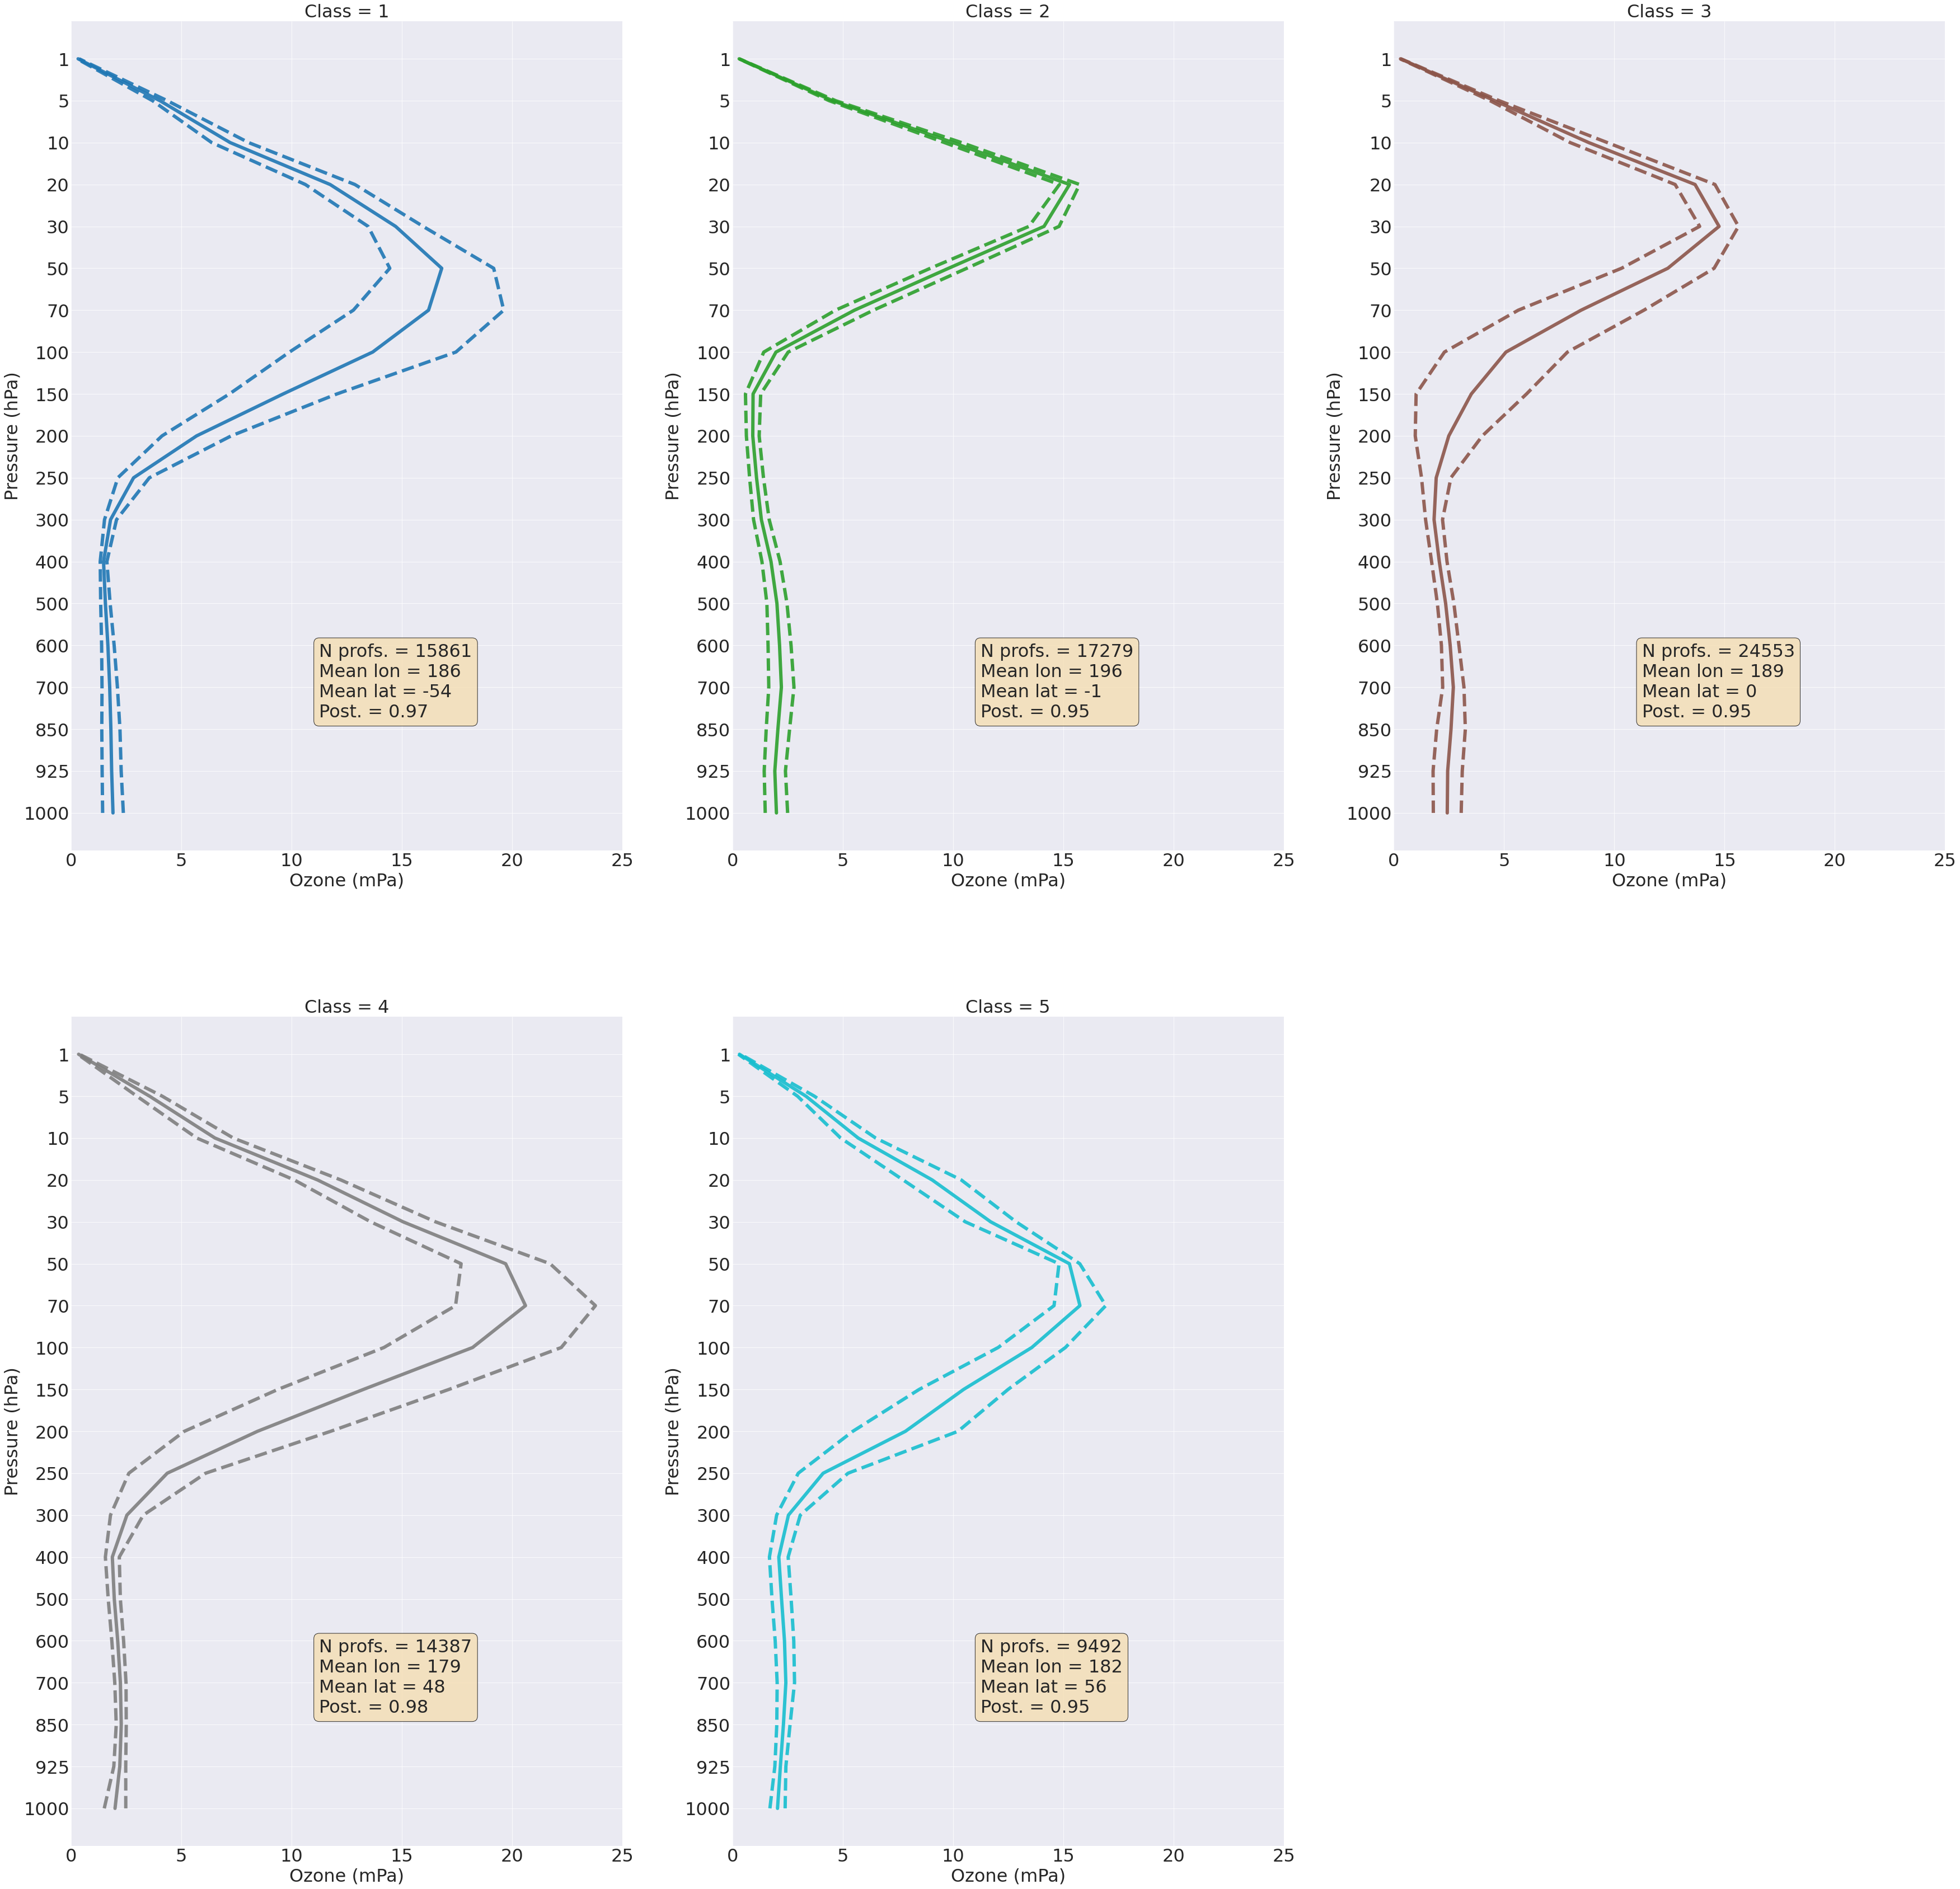

In [47]:
cNorm = colors.Normalize(vmin=0, vmax=n_comp)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

# initialize the figure
plt.figure(figsize=(60, 60))
plt.style.use('seaborn-darkgrid')
#palette = cmx.Paired(np.linspace(0,1,n_comp))

# declare arrays
max_ozone_pressure_ssp126 = np.zeros(n_comp)
max_ozone_value_ssp126 = np.zeros(n_comp)
std_ozone_value_ssp126 = np.zeros(n_comp)
 
 
# iterate over groups
num = 0
for nrow in range(0,n_comp):
    num += 1
    colorVal = scalarMap.to_rgba(nrow)
     # extract means
    mean_lon2 = dfg_means2.iloc[nrow,0]
    mean_lat2 = dfg_means2.iloc[nrow,1]
    mean_maxpp2 = dfg_means2.iloc[nrow,3]
    mean_T2 = dfg_means2.iloc[nrow,4:].values
    
    # extract stdevs
    std_lon2 = dfg_stds2.iloc[nrow,0]
    std_lat2 = dfg_stds2.iloc[nrow,1]
    std_maxpp2 = dfg_stds2.iloc[nrow,3]
    std_T2 = dfg_stds2.iloc[nrow,4:].values
    
    
    # calculate it
    max_ozone_pressure_ssp126[nrow] = p[np.argmax(mean_T2)]
    max_ozone_value_ssp126[nrow] = np.max(mean_T2)
    std_ozone_value_ssp126[nrow] = np.max(std_T2)
    
    print('Class'+str(num))
    print('Maximum at ' + str(max_ozone_pressure_ssp126[nrow]) + ' hPa')
    print('Maximum ozone value of mean profile = ' + str(max_ozone_value_ssp126[nrow]))
    print('Standard deviation at level = ' + str(std_ozone_value_ssp126[nrow]))
    
    
    # select subplot
    #plt.subplot(np.ceil(n_comp/5),5,num)
    plt.subplot(int(np.ceil(n_comp/3)),3,num)
    plt.plot(mean_T2, p1, marker='', linestyle='solid', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T2+std_T2, p1, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T2-std_T2, p1, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    #plt.ylim([0,950])
    ax = plt.gca()
    #ax.invert_yaxis() 
    plt.xlim([0, 25])
    #ax.grid(True)
    
   #text box
    fs = 32 # font size
    plt.xlabel('Ozone (mPa)', fontsize=fs)
    plt.ylabel('Pressure (hPa)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    mpl.rc('xtick', labelsize=fs)     
    mpl.rc('ytick', labelsize=fs)
    
    # this creates the test boxes that display the class statistics
    textstr = '\n'.join((
        r'N profs. = %i' % (nprofs2[nrow], ),
        r'Mean lon = %i' % (mean_lon2, ),
        r'Mean lat = %i' % (mean_lat2, ),
        r'Post. = %.2f' % (mean_maxpp2, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    # place a text box in upper left in axes coords
    ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs,
            verticalalignment='top', bbox=props)   
   #plt.show()

# later, uncomment these to save the figures
plt.savefig("figures/ssp126profiles.pdf",
           bbox_inches="tight",transparent=False)

In the inset text boxes above, "N profs." is the number of profiles in each class. Also shown are class mean values for longitude, latitude, and maximum posterior probability.

#### Plot the label map

In [ ]:
#colormap with carbon emission reduction (SSP126)

# select year if plotting one individual year
#df2plot=df2.loc[df2['year'] == 2100] 

# median label across the 10-year sample
df2plot = df2.groupby(['x','y']).median().reset_index().drop(columns=['year'])
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
#ax.stock_img()
ax.coastlines()

cplot = df2plot['label_sorted'].values + 1

CS2 = plt.scatter(df2plot['x'].values, df2plot['y'].values, c=cplot,
                 marker='o',cmap= colormap, s=6.0,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 #)

colorbar = plt.colorbar(CS2, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)
colorbar.ax.tick_params(labelsize='large')
plt.title('SSP1-2.6 Scenario', fontsize=18) 
#plt.show()

# eventually, uncomment this in order to save the images#if save_figs==True:
plt.savefig("figures/ssp126_labels",bbox_inches="tight",transparent=False)

#### Area calculation

In [ ]:
df2['cos_lat'] = np.cos(np.radians(df2['y']))
A2 = df2.groupby('label_sorted').sum()['cos_lat']
area_ssp126 = 100*A2/np.sum(A2)
area_ssp126

#### SSP5-8.5 (Annual mean from 2090-2100 with no greenhouse emission reduction)

In [ ]:
# keep 'data' as the unmodified original dataset
data_cleaned3 = data3 #ssp585

# drop rows with NaNs
data_cleaned3 = data_cleaned3.dropna()
data_cleaned3 = data_cleaned3.reset_index(drop=True)

# let's work with the cleaned up dataset
df3 = data_cleaned3

# get the latitudes, and longitudes for each profile
lon = df3.iloc[:,0].values
lat = df3.iloc[:,1].values
year = df3.iloc[:,2].values

# get the array that will be used to fit the GMM object
X3 = df3.iloc[:,3:].values

# number of profiles
nProfiles3 = X3[:,1].size
nProfiles3
# scale by variable
Xscaled3 = preprocessing.scale(X3)

In [ ]:
# transform input data into PCA representation
Xpca3 = pca.transform(Xscaled3)

# calculated total variance explained
total_variance_explained_ = np.sum(pca.explained_variance_ratio_) 
total_variance_explained_


# select colormap
#colormap = plt.get_cmap('rainbow', n_comp)

# assign class labels ("predict" the class using the selected GMM)
labels3 = best_gmm.predict(Xpca3)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs3 = best_gmm.predict_proba(Xpca3)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs3 = np.max(posterior_probs3,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
df3.insert(3,'label',labels3,True)
df3.insert(4,'max posterior prob',max_posterior_probs3,True)

In [ ]:
# group by label
grouped_unsorted3 = df3.groupby('label')

# calculate mean of all profiles in each class
df_means3 = grouped_unsorted3.mean()

oz_means3 = df_means3['y'].values

old2new3 = np.argsort(oz_means3)

# create dictionary object for sorting
di3 = dict(zip(old2new3,range(0,n_components_selected)))

# add new column to dataframe - sorted label
df3.insert(4,'label_sorted',df3['label'].map(di3))


In [ ]:
# classes 7 and 8 (python 6 and 7) are very similar

if manual_grouping==True:
    df0 = df3
    for i in range(0,n_components_selected):
        df3.loc[df0.label_sorted==i, "label_sorted"] = manual_classes[i]

# check to see the highest-valued label
print("Number of classes (after manual grouping)")
df3.label_sorted.max()+1

In [ ]:
# group profiles according to label
grouped3 = df3.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means3 = grouped3.mean()

# calculate stdevs of all profiles in each class
dfg_stds3 = grouped3.std()

# number or profiles in each class
nprofs3 = grouped3['x'].count().values

In [ ]:
dfg_means3

In [ ]:
# count number of profiles at each location
gbl3 = df3.groupby('x')
Al3=gbl3.count()['label_sorted']
nprofs3_ = Al3[df3['x'].values].values

In [ ]:
dfg_means3['1000']

In [ ]:
dfg_stds3['1000']

In [ ]:
dfg_stds3

In [ ]:
#classes for no carbon emission reduction (SSP585)
cNorm = colors.Normalize(vmin=0, vmax=n_comp)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

# initialize the figure
plt.figure(figsize=(60, 60))
plt.style.use('seaborn-darkgrid')
#palette = cmx.Paired(np.linspace(0,1,n_comp))

# declare arrays
max_ozone_pressure_ssp585 = np.zeros(n_comp)
max_ozone_value_ssp585 = np.zeros(n_comp)
std_ozone_value_ssp585 = np.zeros(n_comp)
 
# iterate over groups
num = 0
for nrow in range(0,n_comp):
    num += 1
    colorVal = scalarMap.to_rgba(nrow)
     # extract means
    mean_lon3 = dfg_means3.iloc[nrow,0]
    mean_lat3 = dfg_means3.iloc[nrow,1]
    mean_maxpp3 = dfg_means3.iloc[nrow,4]
    mean_T3 = dfg_means3.iloc[nrow,5:].values
    
    # extract stdevs
    std_lon3 = dfg_stds3.iloc[nrow,0]
    std_lat3 = dfg_stds3.iloc[nrow,1]
    std_maxpp3 = dfg_stds3.iloc[nrow,4]
    std_T3 = dfg_stds3.iloc[nrow,5:].values
    
     # calculate it
    max_ozone_pressure_ssp585[nrow] = p[np.argmax(mean_T3)]
    max_ozone_value_ssp585[nrow] = np.max(mean_T3)
    std_ozone_value_ssp585[nrow] = np.max(std_T3)
    
    print('Class'+str(num))
    print('Maximum at ' + str(max_ozone_pressure_ssp585[nrow]) + ' hPa')
    print('Maximum ozone value of mean profile = ' + str(max_ozone_value_ssp585[nrow]))
    print('Standard deviation at level = ' + str(std_ozone_value_ssp585[nrow]))
    
    
    # select subplot
    plt.subplot(np.ceil(n_comp/5),3,num)
    #plt.subplot(3,3,num)
    plt.plot(mean_T3, p1, marker='', linestyle='solid', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T3+std_T3, p1, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T3-std_T3, p1, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    #plt.ylim([0,950])
    ax = plt.gca()
    #ax.invert_yaxis() 
    plt.xlim([0, 25])
    #ax.grid(True)
    
   #text box
    fs = 32 # font size
    plt.xlabel('Ozone (mPa)', fontsize=fs)
    plt.ylabel('Pressure (hPa)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    mpl.rc('xtick', labelsize=fs)     
    mpl.rc('ytick', labelsize=fs)
    
    # this creates the test boxes that display the class statistics
    textstr = '\n'.join((
        r'N profs. = %i' % (nprofs3[nrow], ),
        r'Mean lon = %i' % (mean_lon3, ),
        r'Mean lat = %i' % (mean_lat3, ),
        r'Post. = %.2f' % (mean_maxpp3, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    # place a text box in upper left in axes coords
    ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs,
            verticalalignment='top', bbox=props)   
   
   #plt.show()
plt.savefig("figures/ssp585profiles.pdf",
           bbox_inches="tight",transparent=False)

In the inset text boxes above, "N profs." is the number of profiles in each class. Also shown are class mean values for longitude, latitude, and maximum posterior probability.

In [ ]:
# select year if plotting individual year 

#df3plot=df3.loc[df3['year']==2100]

# median label across the 10-year sample
df3plot = df3.groupby(['x','y']).median().reset_index().drop(columns=['year'])
#colormap with no carbon emission reduction (SSP585)
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
#ax.stock_img()
ax.coastlines()

cplot = df3plot['label_sorted'].values + 1

CS3 = plt.scatter(df3plot['x'].values, df3plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,s=6.0,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 

colorbar = plt.colorbar(CS3, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)
colorbar.ax.tick_params(labelsize='large')
plt.title('SSP5-8.5 Scenario', fontsize=18) 
#plt.show()

# eventually, uncomment this in order to save the images
if save_figs==True:
    plt.savefig("figures/ssp585_labels",bbox_inches="tight",transparent=False)
#plt.savefig("figures/ssp585_labels",bbox_inches="tight",transparent=False)

In [ ]:
df3['cos_lat'] = np.cos(np.radians(df3['y']))
A3 = df3.groupby('label_sorted').sum()['cos_lat']

area_ssp585 = 100*A3/np.sum(A3)
area_ssp585

## Next section is to generate table in latex script directly from here

#### Ozone concentartion at surface (1000 hPa)

In [ ]:
#generate table
# historical
surface_means_hist = df1[['label_sorted','1000']].groupby('label_sorted').mean()
surface_stds_hist  = df1[['label_sorted','1000']].groupby('label_sorted').std()

# SSP126
surface_means_ssp126 = df2[['label_sorted','1000']].groupby('label_sorted').mean()
surface_stds_ssp126  = df2[['label_sorted','1000']].groupby('label_sorted').std()

# SSP585
surface_means_ssp585 = df3[['label_sorted','1000']].groupby('label_sorted').mean()
surface_stds_ssp585  = df3[['label_sorted','1000']].groupby('label_sorted').std()

# establish table 
header = ['Class','Hist (mean)','(std)','SSP126 (mean)','(std)','SSP585 (mean)','(std)']
A = pd.concat([pd.Series((1,2,3,4,5,6)),
               surface_means_hist,
               surface_stds_hist,
               surface_means_ssp126,
               surface_stds_ssp126,
               surface_means_ssp585,
               surface_stds_ssp585],axis=1).round(2)
rows = A.values.tolist()
rows.append(header)
surface_table = rows[-1:]+rows[:-1]
surface_table

# create table object
table = Texttable()
#table.set_cols_align(["c"] * 7)
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(surface_table)

print('\nTexttable Table:')
print(table.draw())

print('\nTexttable Latex:')
print(latextable.draw_latex(table, caption="Ozone concentration statistics at 1000 hPa for the historical, SSP126, and SSP585 experiments, shown in mPa"))

In [ ]:
from tabulate import tabulate
from texttable import Texttable

import latextable

# create list of lists for table
header = ['Class', 'Historical', 'SSP126', 'SSP585']
all_areas = pd.concat([pd.Series((1,2,3,4,5,6)),area_hist, area_ssp126, area_ssp585], axis=1).round(1)
rows = all_areas.values.tolist()
rows.append(header)
area_table = rows[-1:]+rows[:-1]

# create table object
table = Texttable()
table.set_cols_align(["c"] * 4)
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(area_table)

print('\nTexttable Table:')
print(table.draw())

print('\nTexttable Latex:')
print(latextable.draw_latex(table, caption="Relative area occupied by each class, shown in percentages."))

In [ ]:
names = pd.Series(('Southern Hemispheric (Classes 1+2)',
                                        'Tropical (Classes 3+4)',
                                        'Northern Hemispheric (Classes 5+6)'))

m1 = pd.Series(all_areas.iloc[0:2,1:].sum().values.round(1).tolist())  # returns the row for 1+2 (southern hemisphere)
m2 = pd.Series(all_areas.iloc[2:4,1:].sum().values.round(1).tolist())  # returns the row for 3+4 (tropics)
m3 = pd.Series(all_areas.iloc[4:6,1:].sum().values.round(1).tolist())  # returns the row for 5+6 (northern hemisphere)
areas_by_region = pd.concat([m1,m2,m3], axis=1).round(1).T

header = ['Historical', 'SSP126', 'SSP585']
rows = areas_by_region.values.tolist()
rows.append(header)
area_region_table = rows[-1:]+rows[:-1]

In [ ]:
area_region_table

In [ ]:
# create table object
table = Texttable()
table.set_cols_align(["c"] * 3)
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(area_region_table)

print('\nTexttable Table:')
print(table.draw())

print('\nTexttable Latex:')
print(latextable.draw_latex(table, caption="Relative area coverage of three combined regions, shown in percentages."))